# Implementing Convolutional Networks

This notebook demonstrates how convolutional networks learn. The network learned too slow to fully train a network of any significant size, but I was able to demonstrate that the network can learn. I could have tried to optimize the heck out of my code, but eventually decided that it was not worth it, as there are many libraries that provide the same functionality.

## Load Data

In [1]:
from typing import *
import numpy as np
from matplotlib import pyplot as plt
from data_loader import load_data

In [2]:
np.set_printoptions(suppress=True, precision=2)
np.random.seed(1)

In [3]:
# Could take 10 to 20 seconds
train_images, train_labels, test_images, test_labels = load_data()

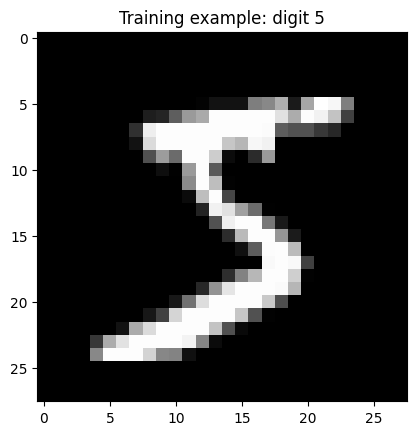

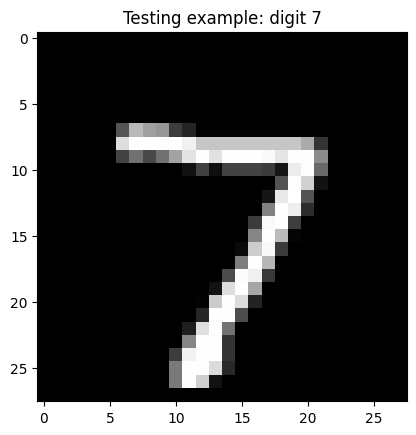

In [4]:
image, label = train_images[0], train_labels[0]
plt.imshow(image, interpolation="nearest", cmap='gray')
plt.title("Training example: digit " + str(np.argmax(label)))
plt.show()

image, label = test_images[0], test_labels[0]
plt.imshow(image, interpolation="nearest", cmap='gray')
plt.title("Testing example: digit " + str(label))
plt.show()

#### Collect into tuples

Note that for MLP architectures it is necessary to flatten the images first (or add a `Flatten` layer at the start of the network).

In [5]:
training_data = [(x, y) for x, y in zip(train_images, train_labels)]
testing_data = [(x, y) for x, y in zip(test_images, test_labels)]

## Simple CNN

As my current implementation of convolutional layers is very slow, I first decided to implement a very basic CNN (a single convolutional layer, pooling layer, and fully connected layer) to make sure the convolutional network is able to learn correctly.

### Initialize the network

In [6]:
from network import Network
from layers import *
from loss import *

In [65]:
layers = [
    Conv2D((28, 28), (5, 5), regularization_parameter=0.2),
    MaxPool2D((24, 24), 2),
    Flatten((12, 12)),
    ReLU(144),
    Dense(144, 10, 0.2),
    ReLU(10),
    Softmax(10)
]
network = Network(layers, 0.01, 10)

##### Initial kernel

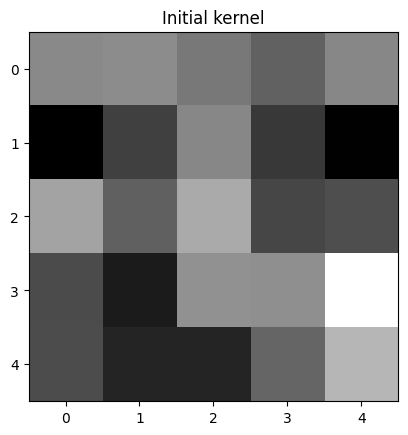

In [66]:
plt.imshow(network.layers[0].kernel, interpolation="nearest", cmap='gray')
plt.title("Initial kernel")
plt.show()

### Feed forward with random parameters

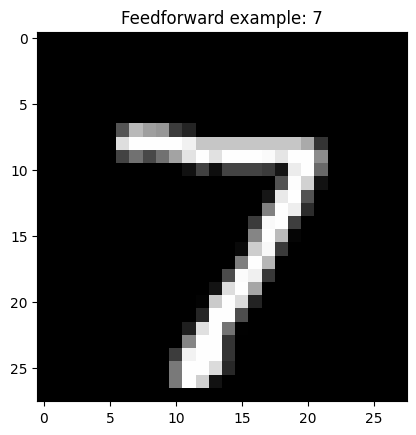

Network output: [0.48 0.12 0.04 0.04 0.04 0.04 0.08 0.04 0.04 0.11]


In [67]:
network.reset()
image, label = testing_data[0]
plt.imshow(image.reshape((28, 28)), interpolation="nearest", cmap='gray')
plt.title("Feedforward example: " + str(label))
plt.show()
network.set_training(False)
print("Network output:", network.forward(image))

### Train the network

In [68]:
# Training takes a long time (~4 minutes per epoch on my machine) as the
# convolution operation is implemented in python right now.

# This network only has one convolutional layer for this reason.
# This network is intended to demonstrate learning is possible, rather than 
# achieve a particularly high accuracy.

# Working on implementing the convolution in C, then calling that function from
# python.
network.reset()
network.set_training(True)

correct = network.evaluate(testing_data[:100])
percent = round(correct / 100, 1)
print(f"Epoch 0: {correct} / 10000 ({percent}%)")

network.train(30, training_data[:100], NLL(), testing_data[:100])

Epoch 0: 10 / 10000 (0.1%)
Epoch 1: 12 / 100 (12.0%)
Epoch 2: 11 / 100 (11.0%)
Epoch 3: 16 / 100 (16.0%)
Epoch 4: 20 / 100 (20.0%)
Epoch 5: 16 / 100 (16.0%)
Epoch 6: 23 / 100 (23.0%)
Epoch 7: 29 / 100 (29.0%)
Epoch 8: 29 / 100 (29.0%)
Epoch 9: 29 / 100 (29.0%)
Epoch 10: 30 / 100 (30.0%)
Epoch 11: 34 / 100 (34.0%)
Epoch 12: 31 / 100 (31.0%)
Epoch 13: 39 / 100 (39.0%)
Epoch 14: 36 / 100 (36.0%)
Epoch 15: 35 / 100 (35.0%)
Epoch 16: 32 / 100 (32.0%)
Epoch 17: 36 / 100 (36.0%)
Epoch 18: 39 / 100 (39.0%)
Epoch 19: 35 / 100 (35.0%)
Epoch 20: 38 / 100 (38.0%)
Epoch 21: 35 / 100 (35.0%)
Epoch 22: 37 / 100 (37.0%)
Epoch 23: 39 / 100 (39.0%)
Epoch 24: 36 / 100 (36.0%)
Epoch 25: 38 / 100 (38.0%)
Epoch 26: 36 / 100 (36.0%)
Epoch 27: 36 / 100 (36.0%)
Epoch 28: 37 / 100 (37.0%)
Epoch 29: 37 / 100 (37.0%)
Epoch 30: 38 / 100 (38.0%)


##### Learned kernel

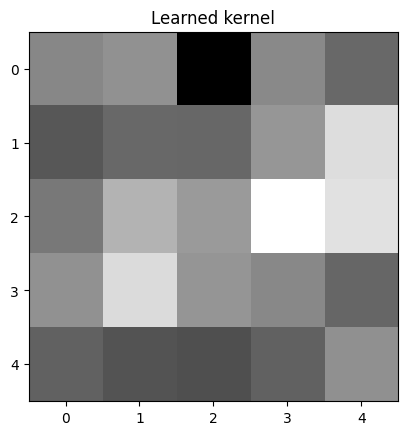

In [69]:
plt.imshow(network.layers[0].kernel, interpolation="nearest", cmap='gray')
plt.title("Learned kernel")
plt.show()

As we can see there are clear edge-like features of the learned kernel, which suggests the network is doing some learning.

In the next section, I implement a deeper CNN with several convolutional layers and max pooling.

## Deep CNN

Since the forward pass involves passing the same input to convolutional layers in parallel, we need to define our own network class and override the `forward` and `train_batch` method.

The following architecture uses five convolutions with 5x5 kernels, another convolution layer, and then two fully connected layers.

In [96]:
class ConvNet(Network):
    
    def __init__(
        self,
        learning_rate: np.float64,
        mini_batch_size: int
    ) -> None:
        self.conv_layers = [
            Conv2D((28, 28), (5, 5), regularization_parameter=0.1),
            Conv2D((28, 28), (5, 5), regularization_parameter=0.1),
            Conv2D((28, 28), (5, 5), regularization_parameter=0.1),
        ]
        self.pool_layers = [
            MaxPool2D((24, 24), 2),
            MaxPool2D((24, 24), 2),
            MaxPool2D((24, 24), 2),
        ]
        self.dense_stack = [
            Flatten((3, 12, 12)),
            Dense(3*12*12, 30, regularization_parameter=0.2),
            LeakyReLU(30, 0.1),
            Dense(30, 10, regularization_parameter=0.2),
            LeakyReLU(30, 0.1),
            Softmax(10),
        ]
        super().__init__(
            [*self.conv_layers, *self.pool_layers, *self.dense_stack],
            learning_rate,
            mini_batch_size
        )
    
    def forward(self, data: np.ndarray) -> np.ndarray:
        data = data.copy()
        data = [self.conv_layers[i].forward(data) for i in range(3)]
        data = np.array([self.pool_layers[i].forward(data[i]) for i in range(3)])
        for layer in self.dense_stack:
            data = layer.forward(data)
        
        return data

    def train_batch(
        self,
        loss: Loss,
        mini_batch: np.ndarray,
        training_size: int
    ) -> None:
        for input_data, target_data in mini_batch:
            output_data = self.forward(input_data)

            error = loss.error(output_data, target_data)

            for layer in reversed(self.dense_stack):
                error = layer.backprop(error)
            
            for i, channel_error in enumerate(error.reshape((3, 12, 12))):
                channel_error = self.pool_layers[i].backprop(channel_error)
                channel_error = self.conv_layers[i].backprop(channel_error)

        for layer in self.layers:
            if layer.trainable:
                layer.regularize_parameters(training_size, self.learning_rate)
                layer.update_parameters(self.learning_rate / len(mini_batch))

In [121]:
network = ConvNet(0.02, 10)

### Initial weights

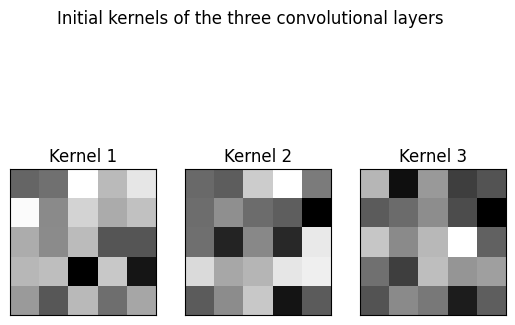

In [122]:
network.reset()

fig, axes = plt.subplots(1, 3)
fig.suptitle("Initial kernels of the three convolutional layers")
for i, conv_layer in enumerate(network.conv_layers):
    ax = axes[i]
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(conv_layer.kernel, interpolation="nearest", cmap="gray")
    ax.set_title(f"Kernel {i+1}")

plt.show()

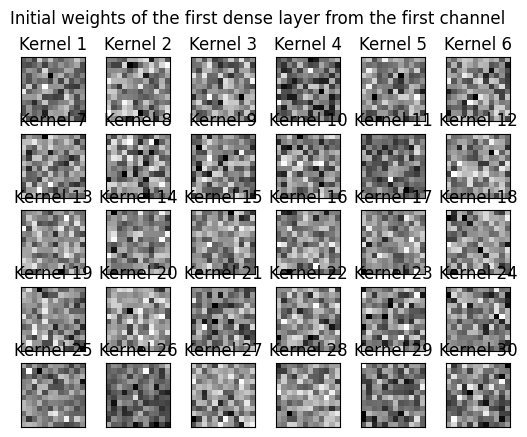

In [123]:
dense = network.dense_stack[1]

fig, axes = plt.subplots(5, 6)
fig.suptitle("Initial weights of the first dense layer from the first channel")
for i in range(30):
    ax = axes[i // 6, i % 6]
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(dense.weights[i][:144].reshape((12, 12)), interpolation="nearest", cmap="gray")
    ax.set_title(f"Kernel {i+1}")

plt.show()

### Feed forward with random parameters

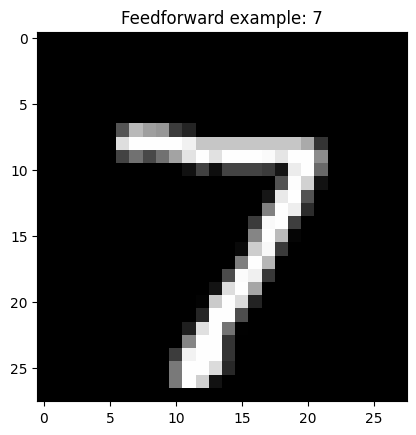

Network output: [0.05 0.05 0.11 0.04 0.05 0.05 0.1  0.04 0.03 0.49]


In [110]:
# network.reset()
image, label = testing_data[0]
plt.imshow(image.reshape((28, 28)), interpolation="nearest", cmap='gray')
plt.title("Feedforward example: " + str(label))
plt.show()
network.set_training(False)
print("Network output:", network.forward(image))

### Train network on small dataset

In [124]:
# network.reset()
network.set_training(True)

# correct = network.evaluate(testing_data)
# percent = round(correct / 100, 1)
# print(f"Epoch 0: {correct} / 10000 ({percent}%)")

# just using the first 1000 training examples because the network is slow
# inevitably leads to severe overfitting
network.train(30, training_data[:1000], NLL())

Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished
Epoch 30 finished


In [128]:
new = training_data[:1000].copy()
new = [(x, np.argmax(y)) for x, y in new]
correct = network.evaluate(new)
percent = round(correct / 100, 1)
print(f"{correct} / 10000 ({percent}%)")

970 / 10000 (9.7%)


### Learned kernels

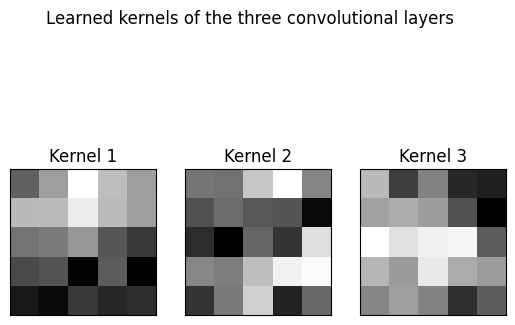

In [126]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Learned kernels of the three convolutional layers")
for i, conv_layer in enumerate(network.conv_layers):
    ax = axes[i]
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(conv_layer.kernel, interpolation="nearest", cmap="gray")
    ax.set_title(f"Kernel {i+1}")

plt.show()

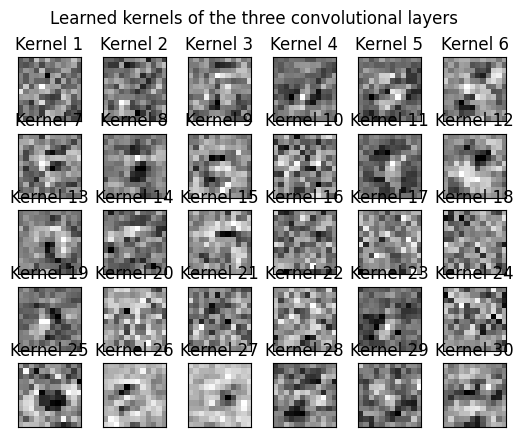

In [127]:
dense = network.dense_stack[1]

fig, axes = plt.subplots(5, 6)
fig.suptitle("Learned kernels of the three convolutional layers")
for i in range(30):
    ax = axes[i // 6, i % 6]
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(dense.weights[i][:144].reshape((12, 12)), interpolation="nearest", cmap="gray")
    ax.set_title(f"Kernel {i+1}")

plt.show()

### Test the Network on My Handwriting

The following code uses images of digits I wrote myself, and tests the model's performance on these digits.

In [13]:
from matplotlib.image import imread

In [14]:
images = []
for i in range(10):
    image = imread("my_handwriting/" + str(i) + ".jpg")
    # Convert image to grayscale
    image = (0.2989*image[:,:,0] + 0.5870*image[:,:,1] + 0.1140*image[:,:,2])
    image /= 256
    images.append(image)

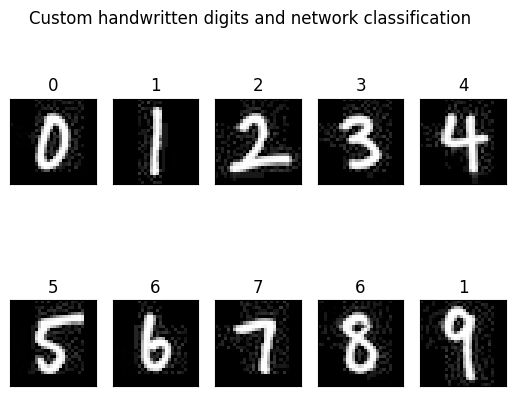

In [16]:
network.set_training(False)

fig, axes = plt.subplots(2, 5)
fig.suptitle("Custom handwritten digits and network classification")
for i in range(10):
    ax = axes[i // 5, i % 5]
    im = images[i]
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")
    ax.set_title(str(np.argmax(network.forward(im))))

plt.show()